# Предсказание температуры стали

## Описание проекта

### Цель проекта

Металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.   
Необходимо построить модель, которая предскажет температуру стали.   
Требуемая точность модели:  
$$ MAE < 6.8$$

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»)
.
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавк
и.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:  
* `data_arc_new.csv` — данные об электродах;
* `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
* `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
* `data_gas_new.csv` — данные о продувке сплава газом;
* `data_temp_new.csv` — результаты измерения температуры;
* `data_wire_new.csv` — данные о проволочных материалах (объём);
* `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.работки.
.работки.

## Первичный анализ данных

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score

from sklearn.dummy import DummyRegressor

### Данные об электродах

#### Анализ данных

In [4]:
try:
    data_arc = pd.read_csv('datasets\\data_arc_new.csv', parse_dates=[1,2])
except:
    data_arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv', parse_dates=[1,2]) 

In [5]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Одному ключу может соответствовать несколько записей в датасете.  
Для построения модели предсказаний нам нужно привести данные к виду один ключ - одна запись.  

Точное время начала и конца нагрева нас мало интересует, более интересна длительность нагрева. Длительность является разностью конца и начала нагрева.  
Так как нам нужно привести всё к одной записи, то можно было бы сложить общую длительность нарева. Однако на разных этапах подаётся разная мощность, что не позволяет нам просто сложить интервалы нагрева.   
Результатом нарева является работа, совершённая электродом. Работа вычисляется как произведение времени на мощность. И работу можно уже сложить по каждому этапу в общую сумму.  
Суммарная совершённая работа, будет достоверно отображать процесс нагрева.

Также интересна общая длина процесса обработки стали, так как в течение всего процесса сталь остывает под действием внешней среды. Вычислить общую длину процесса можно как разность начала первого нагрева и конец последнего.  

К сожалению, после окончания последнего нагрева, со сталью могут проводить некоторые манипуляции, отображённые в других датасетах. И общую длину процесса следовало бы измерять по окончании всех процедур. Однако, сделать это нельзя, из-за того что в разных датасетах часы не синхронизированы и это может привести к ошибкам в данных.  

In [6]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Пропусков нет

In [7]:
data_arc.describe().loc[['count','min','50%','max']]

,key,Активная мощность,Реактивная мощность
count,14876.0,14876.000000,14876.000000
min,1.0,0.223120,-715.479924
50%,1617.0,0.599587,0.441639
max,3241.0,1.463773,1.270284


В столбце реактивной мощности выделяется минимальное значение меньше 0. Это явная ошибка, мощность не может быть меньше нуля.  
Посмортим сколько таких значений встречается в данных.

In [8]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Всего одна запись, от неё нужно будет избавиться при обработке данных.

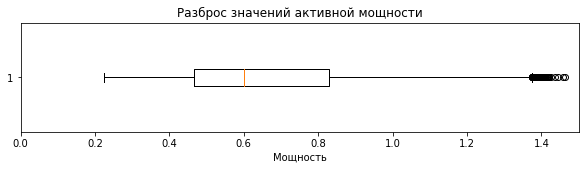

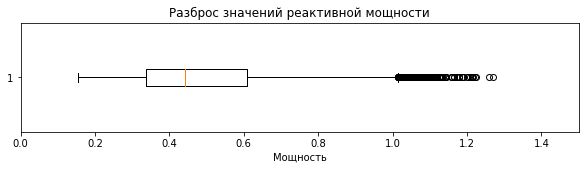

In [9]:
plt.figure(figsize=(10, 2))
plt.boxplot(data_arc[['Активная мощность']],vert=False)
plt.title('Разброс значений активной мощности')
plt.xlabel('Мощность')
plt.xlim(0,1.5)
plt.show();
plt.figure(figsize=(10, 2))
plt.boxplot(data_arc[['Реактивная мощность']],vert=False)
plt.title('Разброс значений реактивной мощности')
plt.xlabel('Мощность')
plt.xlim(0,1.5)
plt.show();

Помимо одной ошибки данные выглядят нормально.  
Выбросы присутствуют, но не выглядят аномально большими.

Проверим корреляцию данных

In [10]:
data_arc.drop('key',axis=1).corr().style.background_gradient(cmap='coolwarm', axis=0, vmin=0, vmax=1)

,Активная мощность,Реактивная мощность
Активная мощность,1.000000,0.031164
Реактивная мощность,0.031164,1.000000


Корреляция мощностей почти нулевая, однако мы помним, что в наборе есть одно неверное значение. Посмотрим какой будет результат без него.

In [11]:
(data_arc[data_arc['Реактивная мощность'] > 0].drop('key',axis=1).corr().
     style.background_gradient(cmap='coolwarm',axis=0, vmin=0, vmax=1))

,Активная мощность,Реактивная мощность
Активная мощность,1.000000,0.966373
Реактивная мощность,0.966373,1.000000


Совсем другой результат. Как сильно может повлиять одна неверная запись.  

Теперь появляется вопрос: следует ли оставить в датасете только активную мощность, либо вычислить полную?  
Я выбираю вариант с активной мощностью. Так как именно активная мощность влияет непосредственно на сталь, а реактивная мощность является побочными затратами энергии.

#### Вывод

Пропусков в датасете нет.  
Ошибка содержится только в одной записи с отрицательной мощьностью. Все данные по этому процессу нужно будет удалить.  

Активная и реактивная мощность сильно коррелируют друг с другом. Так как на сталь воздействует именно активная мощьность, в датасете следует оставить только её.

Всю информацию по каждому отдельному процессу следует агрегировать.  
Можно создать новую таблицу со следующими столбцами:
* Ключ процесса;
* Общая длительность процесса от начала первого нагрева, до конца последнего;
* Суммарная активная работа.

Работа вычисляется как произведение времени нагрева, на его активную мощность.

### Данные о подаче сыпучих материалов (объём)

#### Анализ данных

In [12]:
try:
    data_bulk_vol = pd.read_csv('datasets\\data_bulk_new.csv')
except:
    data_bulk_vol = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv') 

In [13]:
data_bulk_vol.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


В данных содержится значительное количество пропусков.  
Пропущенное значение означает, что данный компонент в данном процессе добавлен не был. Значит все пропуски можно заменить на нули.

In [14]:
data_bulk_vol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Количество записей по каждому типу материалов позволяют оценить насколько часто их используют.  
Наиболее редкие материалы можно удалить, однако тогда наша модель не сможет в будущем обрабатывать данные с неизвестными ей материалами. Поэтому можно объединить несколько наименее популярных материалов в категорию `Other` что позволит всё же обработать эти данные без значительных потерь. Но при этом число параметров будет сокращено.

In [15]:
data_bulk_vol.describe().loc[['count','min','50%','max']]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.0,252.0,22.0,1298.0,1014.0,77.0,576.0,25.0,1.0,19.0,176.0,177.0,2450.0,18.0,2806.0,2248.0
min,1.0,10.0,228.0,6.0,12.0,11.0,17.0,47.0,49.0,63.0,24.0,8.0,53.0,151.0,16.0,1.0
50%,1622.0,31.0,251.5,97.5,102.0,86.0,100.0,298.0,49.0,68.0,86.5,64.0,208.0,155.5,151.0,160.0
max,3241.0,185.0,325.0,454.0,281.0,603.0,503.0,772.0,49.0,147.0,159.0,313.0,1849.0,305.0,636.0,405.0


Здесь сильно выбивается только одно значение: максисмум вещества `Bulk 12` равный 1849, в то время как у других столбцов максимум не превышает 900. Т.е. значение 1849 более чем вдвое превышает максимумы других столбцов.  
Проверим, много ли значений больше 900 в столбце `Bulk 12`.

In [16]:
data_bulk_vol[data_bulk_vol['Bulk 12'] > 900]['key'].count()

1

Всего одна запись, скорее всего это ошибка. Вряд ли одна запись может более чем вдвое превышать все прочие.  
Все записи по этому процессу нужно будет удалить.

Теперь можно взглянуть на диаграммы размаха

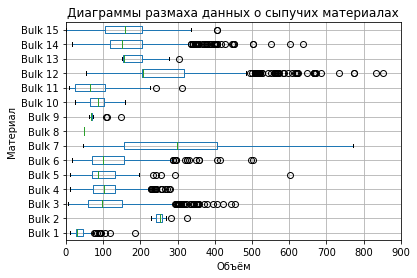

In [17]:
data_bulk_vol.drop('key',axis=1).boxplot(vert=False)
plt.title('Диаграммы размаха данных о сыпучих материалах')
plt.xlabel('Объём')
plt.ylabel('Материал')
plt.xlim(0,900);

Здесь кажется значительным отклонением только выброс около 600 у столбца `Bulk 5`.  
Третий квартиль здесь имеет значение около 200, а максимальный выброс, помимо 600, имеет значение около 300. Что делает значение в 600 для этого столбца аномально высоким. От этой записи также следует избавиться.

Проверим, что каждому представленному ключу соответствует одна запись

In [18]:
data_bulk_vol.key.value_counts().max()

1

#### Вывод

В данных очень много пропусков, все их следует заменить нулями.  

Все редкие материалы следует объединить в один столбец `Other`. 

В наборе присутствует два аномальных выброса, данные об этих процессах следует удалить.  
Выбросы содержатся в строках с максимальным значением столбцов `Bulk 12` и `Bulk 5`.

### Данные о подаче сыпучих материалов (время)

#### Анализ данных

In [19]:
dates = [*range(1,16)]
try:
    data_bulk_time = pd.read_csv('datasets\\data_bulk_time_new.csv',parse_dates=dates)
except:
    data_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv',parse_dates=dates) 

In [20]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [21]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [22]:
data_bulk_time.describe(datetime_is_numeric=True).loc[['count', 'min', 'max']]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.0,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
min,1.0,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
max,3241.0,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15


Данные о времени добавления того или иного материала можно было бы преобразовать в число секунд, прошедших с начла процесса, до добавления материала. Однако во-первых, часы из таблицы о электродах и этой таблицы могут показывать разные значения, а во-вторых вряд ли точный момент добавления материалов или их порядок добавления ирают значительную роль в значении финальной температуры.  

Поэтому в построении модели данную таблицу учитывать не будем.

#### Вывод

В построении модели эта таблица использоваться не будет.

### Данные о продувке сплава газом

#### Анализ данных

In [23]:
try:
    data_gas = pd.read_csv('datasets\\data_gas_new.csv')
except:
    data_gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv') 

In [24]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [25]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропусков в таблице нет

In [26]:
data_gas.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


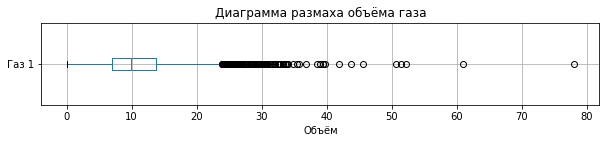

In [27]:
data_gas.drop('key',axis=1).boxplot(vert=False,figsize=(10,1.5))
plt.xlabel('Объём')
plt.title('Диаграмма размаха объёма газа');

Присутствую значительные выбросы, однако вряд ли они являются ошибками. Такие записи можно удалять только из тренировочной выборки.

In [28]:
data_gas.key.value_counts().max()

1

Каждому представленному ключу соответствует одна запись

#### Вывод

В наборе присутствуют значительные выбросы. Их следует удалить, но только после отделения тренировочной выборки от тестовой.

### Данные о проволочных материалах (объём)

Этот датасет по своей сути не отличается от данных об объёме сыпучих материалов, поэтому все замечания я напишу сразу в вывод.

#### Анализ данных

In [29]:
try:
    data_wire_vol = pd.read_csv('datasets\\data_wire_new.csv')
except:
    data_wire_vol = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv') 

In [30]:
data_wire_vol.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
data_wire_vol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [32]:
data_wire_vol.describe().loc[{'count','min','max'}]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
max,3241.0,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604
count,3081.0,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
min,1.0,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800


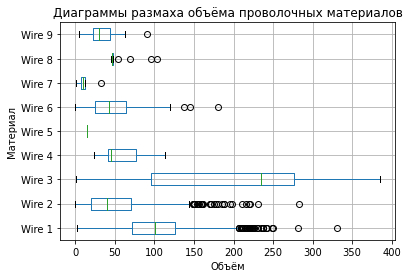

In [33]:
data_wire_vol.drop('key',axis=1).boxplot(vert=False)
plt.xlabel('Объём')
plt.ylabel('Материал')
plt.title('Диаграммы размаха объёма проволочных материалов');

In [34]:
data_wire_vol.key.value_counts().max()

1

Каждому представленному ключу соответствует одна запись

#### Вывод

В данных очень много пропусков, все их следует заменить нулями.

Все редкие материалы следует объединить в один столбец `Other`.

Значительных выбросов в наборе нет.

### Данные о проволочных материалах (время)

#### Анализ данных

In [35]:
try:
    data_wire_time = pd.read_csv('datasets\\data_wire_time_new.csv', parse_dates=[1,2,3,4,5,6,7,8,9])
except:
    data_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv', 
                                 parse_dates=[1,2,3,4,5,6,7,8,9]) 

In [36]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [37]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [38]:
data_wire_time.describe(datetime_is_numeric=True).loc[['count','min','max']]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.0,3055,1079,63,14,1,73,11,19,29
min,1.0,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
max,3241.0,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23


Также как и датасет с временем подачи сыпучих материалов, данный датасет в построении модели использоваться не будет.

#### Вывод

В построении модели эта таблица использоваться не будет.

### Результаты измерения температуры

#### Анализ данных

In [39]:
try:
    data_temp = pd.read_csv('datasets\\data_temp_new.csv', parse_dates=[1])
except:
    data_temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv', parse_dates=[1]) 

In [40]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Каждому ключу может соответствовать несколько записей.  
Нас интересует только первое и последнее измерение, которые следует записать в новые столбцы, а точное время измерения нас не интересует.

In [41]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


В столбце со значением температуры большое количество пропусков.  
Так как температура это целевой параметр, то пропуски в нём недопустимы. Все процессы с пропусками следует удалить.

In [42]:
data_temp.describe().T

,count,mean,std,min,25%,50%,75%,max
key,18092.0,1616.460977,934.641385,1.0,807.75,1618.0,2429.0,3241.0
Температура,14665.0,1590.722741,20.394381,1191.0,1580.00,1590.0,1599.0,1705.0


Температура плавления стали 1450—1520 °C. Все значения меньше 1450 являются ошибочными, их нужно удалить.

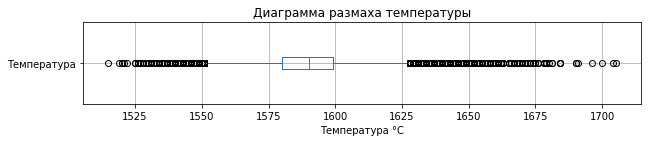

In [43]:
data_temp[data_temp['Температура']>1450].drop('key', axis=1).boxplot(vert=False, figsize=(10,1.5))
plt.title('Диаграмма размаха температуры')
plt.xlabel('Температура °C');

Аномальных выбросов нет

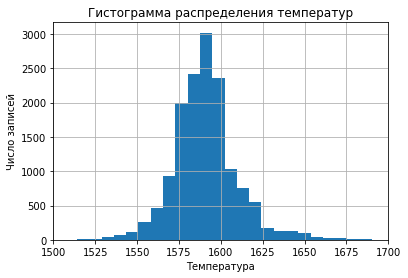

In [44]:
data_temp.drop(['key','Время замера'], axis=1).hist(bins=70, figsize=(6,4))
plt.xlim((1500,1700))
plt.xlabel('Температура')
plt.ylabel('Число записей')
plt.title('Гистограмма распределения температур');

Как видно, график очень похож на нормальное распределение. Это должно хорошо повлиять на построение модели.

Посмотрим число замеров температуры для каждого ключа и построим гистограмму.

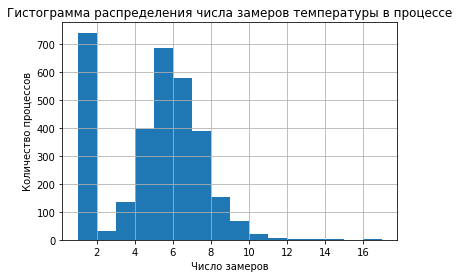

In [45]:
data_temp.groupby(['key']).count()['Температура'].hist(bins=16,figsize=(6,4))
plt.xlabel('Число замеров')
plt.ylabel('Количество процессов')
plt.title('Гистограмма распределения числа замеров температуры в процессе');

Как видно, у большого числа процессов был произведён всего один замер. К сожалению, такие записи нам не подходят и их придётся удалить.   

Также следует выяснить можно ли считать, что если было произведено хотя бы два замера, то можно один был произведён в начале процесса, а второй в конце? Проверить самостоятельно это нельзя, из-за того что время в датафреймах не синхронизировано.

Отдельно на всякий случай проверим, вдруг пропуски в записи темпертур в промежуточных измерениях. Возможно начальное и финальное измерение было произведено, а промежуточные пропущены. В таком случае эти записи необязательно удалять.

In [46]:
# Выделяем ключи, по которым есть попуски
keys = data_temp[data_temp['Температура'].isna()].key.unique()
# Считаем число измерений по каждому ключу
data_temp.loc[data_temp.key.isin(keys)].groupby(['key']).count()['Температура'].value_counts()

1    739
Name: Температура, dtype: int64

Похоже пропуски как раз в тех записях, где только одно измерение. Значит все процессы с пропусками точно нужно удалить.  

In [47]:
data_temp.loc[data_temp.key.isin(keys)]

,key,Время замера,Температура
13926,2500,2019-08-10 14:04:39,1539.0
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


Все пропуски содержатся в процессах с 2500 по 3241, т.е. в последних записях. И единственная присутствующая запись для них это начальная температура стали, т.е. вводные данные.   
Возможно это тестовые данные, для которых нам и нужно было бы в итоге сделать предсказание, которое потом проверят на практике? Если бы это была реальная бизнес задача, а 2019 год давно не прошёл.

#### Вывод

В таблице много пропусков, все процессы с пропусками нужно удалить.   
Также следует удалить процессы в которых было произведено всего одно измерение (вероятно совпадает с процессами с пропусками)

Измерения температуры содержат ошибочные записи со значениями ниже 1450°C, т.е. ниже температуры плавления стали. Такие записи следует удалить.  

Из оставшихся записей нужно сформировать таблицу со следующими столбцами:
* Ключ;
* Начальная температура;
* Финальная температура.

### Вывод по первичному анализу данных

**Данные об электродах**

Пропусков в датасете нет.  
Ошибка содержится только в одной записи с отрицательной мощьностью. Все данные по этому процессу нужно будет удалить.  

Активная и реактивная мощность сильно коррелируют друг с другом. Так как на сталь воздействует именно активная мощьность, в датасете следует оставить только её.

Всю информацию по каждому отдельному процессу следует агрегировать.  
Можно создать новую таблицу со следующими столбцами:
* Ключ процесса;
* Общая длительность процесса от начала первого нагрева, до конца последнего;
* Сумманрная активная работа.

Работа вычисляется как произведение времени нагрева, на его активную мощность.

**Данные о подаче сыпучих материалов (объём)**

В данных очень много пропусков, все их следует заменить нулями.  

Все редкие материалы следует объединить в один столбец `Other`. Редкость столбца следует определить уже после удаления всех ключей с ошибками в измерениях по всем датасетам.  

В наборе присутствует два аномальных выброса, данные об этих процессах следует удалить.  
Выбросы содержатся в строках с максимальным значением столбцов `Bulk 12` и `Bulk 5`.

**Данные о подаче сыпучих материалов (время)**

В построении модели эта таблица использоваться не будет.

**Данные о продувке сплава газом**

В наборе присутствуют значительные выбросы. Их следует удалить, но только после отделения тренировочной выборки от тестовой.

**Данные о проволочных материалах (объём)**

В данных очень много пропусков, все их следует заменить нулями.

Все редкие материалы следует объединить в один столбец Other. Редкость столбца следует определить уже после удаления всех ключей с ошибками в измерениях по всем датасета

Значительных выбросов в наборе нет.

**Данные о проволочных материалах (время)**

В построении модели эта таблица использоваться не будет.

**Результаты измерения температуры**

В таблице много пропусков, все процессы с пропусками нужно удалить.   
Также следует удалить процессы в которых было произведено всего одно измерение (вероятно совпадает с процессами с пропусками)

Измерения температуры содержат ошибочные записи со значениями ниже 1450°C, т.е. ниже температуры плавления стали. Такие записи следует удалить.  

Из оставшихся записей нужно сформировать таблицу со следующими столбцами:
* Ключ;
* Начальная температура;
* Финальная температура.


## План работы

* Подготовка данных
    1. Обработка данных в соответствии с выводами по первичному анализу
    3. Составление единой таблицы методом inner join, в полученной таблице одному ключу должна соответствовать одна запись
    4. Проверка корреляции столбцов
    5. Разделение на тестовую и тренирововчную выборки
    6. Устранение слишком сильных выбросов в тренировочной выборке
    7. Масштабирование данных
* Обучение модели
    1. Логистическая регрессия
    2. Рандомный лес
    3. CatBoost
    4. LightGBM
    6. Выбор лучшей модели
* Анализ полученной модели
    1. Проверка на тестовых данных
    2. Сравнение с dummy моделью
    3. Изучение важности признаков
* Отчёт о проделанной работе

## Вопросы к тим лиду

Если по ключу совершено хотя бы два измерения, мы можем быть уверены, что первое произведено в начале процесса, а последнее в конце? Или нужна дополнительная проверка?

Ответ:  Да, если есть первый и последний (по времени) замеры температуры, то мы можем использовать в модели то, что первый был совершен в начале процесса, а второй в конце.

Если в датасете нет записи по какому-то ключу, это однозначно ошибка или нет?   
Пример: в таблице нет записи о продувке газом по некоторому ключу.   
Может ли быть такое, что в процессе действительно не применялась продувка газом, а значит можно сделать запись с нулём? Или такого быть не должно и при совершнии inner join такие записи автоматически отсеятся?

Ответ: Нет, не может. Если у нас нет данных по какому-нибудь аспекту процесса, то их просто нет, заполнять их нулями не нужно.

## Предобработка данных

In [48]:
random_state=40823

### Данные об электродах

В данных содержится одна ошибка в столбце реактивной мощности. Однако так как было решено использовать в обучении модели только активную работу, на ошибку можно не обращать внимание.

Сначала посчитаем работу каждого этапа и добавим её в таблицу.

In [49]:
data_arc['Активная работа'] = (data_arc['Конец нагрева дугой']-data_arc['Начало нагрева дугой']).dt.seconds * data_arc['Активная мощность']
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Активная работа
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,69.569640
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,141.646730
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,99.813836
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,189.251040
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,128.335684


Теперь создадим новый датасет с суммарной работой.

In [50]:
data_arc_work = pd.DataFrame(data_arc.groupby('key').sum('Активная работа')['Активная работа'])
data_arc_work.head()

,Активная работа
key,
1,628.616930
2,395.281800
3,581.774624
4,543.710274
5,412.180480


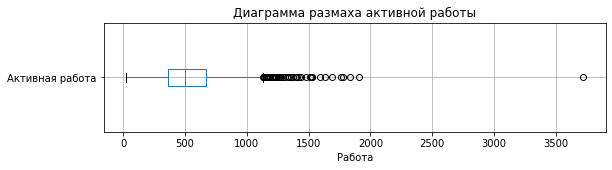

In [51]:
data_arc_work.boxplot(vert=False, figsize=(9,2))
plt.xlabel('Работа')
plt.title('Диаграмма размаха активной работы');

Выделяется один выброс, так как в значениях мощности такх выбросов не было, значит какой-то процесс длился очень долго. 

### Данные о подаче сыпучих материалов (объём)

До заполнения пропущенных значений выберем какие материалы объединить в категорию `Other`. Это удобно сделать по тоблице 
`info`.

In [52]:
data_bulk_vol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Будем считать очень редкими материалы, которые использовались не более чем в 1% процессов. У нас 3129 процессов, значит нас интрересуют числа меньше 31. Это материалы `Bulk 2, Bulk 7, Bulk 8, Bulk 9, Bulk 13`. 

In [53]:
other_columns = ['Bulk 2', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 13']
data_bulk_vol['other_bulk'] = data_bulk_vol.loc[:,other_columns].sum(axis=1)

#Выведем несколько строк с ненулевой суммой других материалов, чтобы проверить результат
(data_bulk_vol[data_bulk_vol['other_bulk']>0].sample(5, random_state=random_state).
     style.format('{0:,.0f}').set_properties(**{'background-color': 'lightcyan'}, subset=other_columns))

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,other_bulk
1882,"1,945",nan,nan,nan,nan,nan,nan,252,nan,nan,nan,nan,nan,nan,nan,nan,252
1485,"1,542",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,111,151,nan,110,151
1541,"1,599",nan,nan,251,nan,nan,56,nan,nan,nan,nan,nan,465,154,132,160,154
2471,"2,563",22,254,nan,38,124,nan,340,nan,nan,nan,nan,nan,nan,nan,nan,594
264,282,nan,nan,80,nan,nan,nan,nan,nan,65,nan,nan,104,nan,256,nan,65


Теперь можно удалить редкие материалы.  
Также установим ключ индексом датасета.

In [54]:
data_bulk_vol = data_bulk_vol.drop(other_columns, axis=1).set_index('key')
data_bulk_vol.head()

,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,other_bulk
key,,,,,,,,,,,
1,NaN,NaN,43.0,NaN,NaN,NaN,NaN,206.0,150.0,154.0,0.0
2,NaN,NaN,73.0,NaN,NaN,NaN,NaN,206.0,149.0,154.0,0.0
3,NaN,NaN,34.0,NaN,NaN,NaN,NaN,205.0,152.0,153.0,0.0
4,NaN,NaN,81.0,NaN,NaN,NaN,NaN,207.0,153.0,154.0,0.0
5,NaN,NaN,78.0,NaN,NaN,NaN,NaN,203.0,151.0,152.0,0.0


Осталось только заполнить пропуски нулями.

In [55]:
data_bulk_vol = data_bulk_vol.fillna(0)
data_bulk_vol.head()

,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,other_bulk
key,,,,,,,,,,,
1,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,0.0
2,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,0.0
3,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,0.0
4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,0.0
5,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0,0.0


Посмотрим диаграмму размаха нового столбца без нулевых значний.

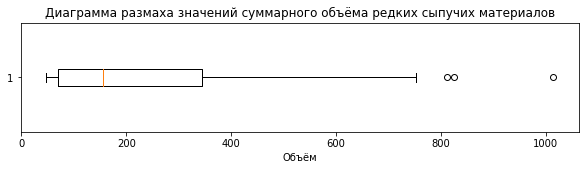

In [56]:
plt.figure(figsize=(10,2))
plt.boxplot(data_bulk_vol.loc[data_bulk_vol['other_bulk'] > 0, 'other_bulk'], vert=False)
plt.title('Диаграмма размаха значений суммарного объёма редких сыпучих материалов')
plt.xlabel('Объём')
plt.show();

Диаграмма выглядит нормально, значительных выбросов или аномальных значений нет.

### Данные о проволочных материалах (объём)

Здесь повторим те же действия, что и с сыпучими материалами.

In [57]:
data_wire_vol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Здесь в котегорию редких выделяем столбцы `Wire 4, Wire 5, Wire 7, Wire 8, Wire 9`

In [58]:
other_columns_wire = ['Wire 4', 'Wire 5', 'Wire 7', 'Wire 8', 'Wire 9']
data_wire_vol['other_wire'] = data_wire_vol.loc[:,other_columns_wire].sum(axis=1)

#Выведем несколько строк с ненулевой суммой других материалов, чтобы проверить результат
(data_wire_vol[data_wire_vol['other_wire']>0].sample(5, random_state=random_state).
     style.format('{0:,.0f}').set_properties(**{'background-color': 'lightcyan'}, subset=other_columns_wire))

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,other_wire
1606,"1,686",115,50,nan,nan,nan,nan,nan,nan,30,30
950,"1,010",nan,nan,nan,nan,nan,nan,nan,nan,17,17
1598,"1,678",100,99,nan,nan,nan,nan,nan,nan,10,10
2341,"2,466",147,120,nan,nan,nan,nan,nan,nan,25,25
264,287,130,60,nan,nan,nan,nan,nan,45,nan,45


Теперь можно удалить редкие материалы.  
Также установим ключ индексом датасета.

In [59]:
data_wire_vol = data_wire_vol.drop(other_columns_wire, axis=1).set_index('key')
data_wire_vol.head()

,Wire 1,Wire 2,Wire 3,Wire 6,other_wire
key,,,,,
1,60.059998,NaN,NaN,NaN,0.0
2,96.052315,NaN,NaN,NaN,0.0
3,91.160157,NaN,NaN,NaN,0.0
4,89.063515,NaN,NaN,NaN,0.0
5,89.238236,9.11456,NaN,NaN,0.0


Осталось только заполнить пропуски нулями.

In [60]:
data_wire_vol = data_wire_vol.fillna(0)
data_wire_vol.head()

,Wire 1,Wire 2,Wire 3,Wire 6,other_wire
key,,,,,
1,60.059998,0.00000,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0


Посмотрим диаграмму размаха нового столбца без нулевых значний.

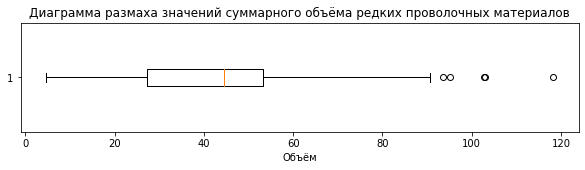

In [61]:
plt.figure(figsize=(10,2))
plt.boxplot(data_wire_vol.loc[data_wire_vol['other_wire'] > 0, 'other_wire'], vert=False)
plt.title('Диаграмма размаха значений суммарного объёма редких проволочных материалов')
plt.xlabel('Объём')
plt.show();

Диаграмма выглядит нормально, значительных выбросов или аномальных значений нет.

### Данные о продувке сплава газом

В этой таблице только назначим ключ индексом, другие изменения не требуются.

In [62]:
data_gas = data_gas.set_index('key')
data_gas.head()

,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


### Результаты измерения температуры

Сначала выберем ключи, для которых совершено два или более измерения.

In [63]:
keys_2 = data_temp.groupby(['key']).count()['Температура']
keys_2 = keys_2[keys_2 > 1].index
keys_2

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            2489, 2490, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499],
           dtype='int64', name='key', length=2475)

Теперь оставим в наборе только эти ключи.

In [64]:
data_temp = data_temp[data_temp.key.isin(keys_2)]
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13924 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13924 non-null  int64         
 1   Время замера  13924 non-null  datetime64[ns]
 2   Температура   13924 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.1 KB


Мы заодно сразу избавились и от пропусков.

In [65]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [66]:
data_temp['Время замера'].is_monotonic_increasing

True

Все записи в датасете приведены в хронологическом порядке. Значит для определения начала и конца процесса можно брать первую и последнюю запись по ключу.

Теперь создадим новую таблицу в которую войдут следующие столбцы:
* Индекс ключ;
* Начало процесса;
* Конец процесса;
* Первый замер температуры;
* Последний замер температуры.

In [67]:
data_temp_agg = (data_temp.groupby('key').agg({'Время замера':['first','last'], 'Температура':['first','last']}))
data_temp_agg.columns = ['Начало процесса', 'Конец процесса', 'Температура в начале', 'Температура в конце']
data_temp_agg.head()

,Начало процесса,Конец процесса,Температура в начале,Температура в конце
key,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0


Теперь заменим столбцы с врменем на один столбец с длительностью в секундах.

In [68]:
data_temp_agg['Длительность'] = (data_temp_agg['Конец процесса'] - data_temp_agg['Начало процесса']).dt.seconds
data_temp_agg = data_temp_agg.drop(['Начало процесса', 'Конец процесса'], axis=1)
data_temp_agg.head()

,Температура в начале,Температура в конце,Длительность
key,,,
1,1571.0,1613.0,1714
2,1581.0,1602.0,1265
3,1596.0,1599.0,1753
4,1601.0,1625.0,1220
5,1576.0,1602.0,1536


In [69]:
data_temp_agg.describe().loc[['min','50%','max']]

,Температура в начале,Температура в конце,Длительность
min,1191.0,1541.0,339.0
50%,1588.0,1593.0,2009.0
max,1679.0,1700.0,23674.0


Длительность имеет очень широкий размах: от 5 минут до 6.5 часов. Медианное значение примерно полчаса.  

У температур не такой большой диапазон значений. Однако тут есть ошибочные записи в столбце начальных температур: температура должна быть выше 1450°C. Удалим ошибочные записи.

In [70]:
data_temp_agg = data_temp_agg[data_temp_agg['Температура в начале'] > 1450]
data_temp_agg.describe().loc[['min','50%','max']]

,Температура в начале,Температура в конце,Длительность
min,1519.0,1541.0,339.0
50%,1588.0,1593.0,2007.0
max,1679.0,1700.0,23674.0


Теперь всё в порядке, можно взглянуть на гистограммы распределений.

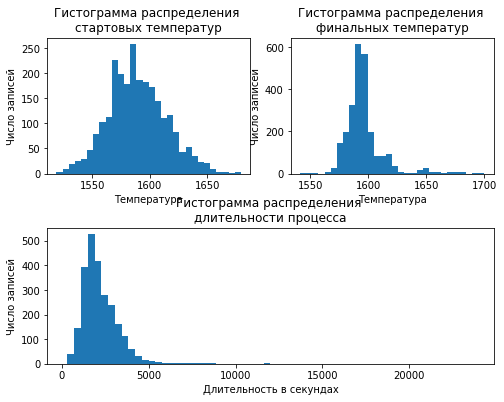

In [71]:
gs = plt.GridSpec(2, 2, hspace=0.4)
fig = plt.figure(figsize=(8,6))

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Гистограмма распределения \nстартовых температур')
ax1.set_xlabel('Температура')
ax1.set_ylabel('Число записей')
ax1.hist(data_temp_agg['Температура в начале'], bins=30)

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Гистограмма распределения \nфинальных температур')
ax2.set_xlabel('Температура')
ax2.set_ylabel('Число записей')
ax2.hist(data_temp_agg['Температура в конце'], bins=30)

ax3 = fig.add_subplot(gs[1, :]) 
ax3.set_title('Гистограмма распределения \nдлительности процесса')
ax3.set_xlabel('Длительность в секундах')
ax3.set_ylabel('Число записей')
ax3.hist(data_temp_agg['Длительность'], bins=60);

Стартовые температуры распределены более-менее равномерно.  
А вот у финальных температур есть заметный хвост в правой части графика. Для предотвращения чрезмерного нагрева стали как раз пригодится разабатываемая модель.

Длительность процесса, как уже отмечалось ранее, имеет довольно широкий диапазон значений. Помимо длинного хвоста, распределение данных похоже на нормальное.

In [72]:
data_temp_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2499
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Температура в начале  2471 non-null   float64
 1   Температура в конце   2471 non-null   float64
 2   Длительность          2471 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 77.2 KB


Пропусков нет, всё в порядке.

## Подготовка данных для обучения

### Формирование единой таблицы

Для формирования единой таблицы подготовлено пять таблиц с индексами по ключу. Теперь достаточно совершить `inner join` по всем таблицам.  
Если в какой-то таблице не было определённого ключа или он был удалён при обработке данных, то такой ключ не попадёт в итоговую таблицу.

In [73]:
data_fin = (data_temp_agg.join(data_arc_work, how='inner').
                            join(data_bulk_vol, how='inner').
                               join(data_wire_vol, how='inner').
                                   join(data_gas, how='inner'))
data_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2499
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Температура в начале  2325 non-null   float64
 1   Температура в конце   2325 non-null   float64
 2   Длительность          2325 non-null   int64  
 3   Активная работа       2325 non-null   float64
 4   Bulk 1                2325 non-null   float64
 5   Bulk 3                2325 non-null   float64
 6   Bulk 4                2325 non-null   float64
 7   Bulk 5                2325 non-null   float64
 8   Bulk 6                2325 non-null   float64
 9   Bulk 10               2325 non-null   float64
 10  Bulk 11               2325 non-null   float64
 11  Bulk 12               2325 non-null   float64
 12  Bulk 14               2325 non-null   float64
 13  Bulk 15               2325 non-null   float64
 14  other_bulk            2325 non-null   float64
 15  Wire 1               

В итоге у нас осталось 2325 записей. Зато без пропусков и ошибок.

In [74]:
pd.set_option('display.max_columns', None)
data_fin.head()

,Температура в начале,Температура в конце,Длительность,Активная работа,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,other_bulk,Wire 1,Wire 2,Wire 3,Wire 6,other_wire,Газ 1
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,1714,628.616930,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,0.0,60.059998,0.00000,0.0,0.0,0.0,29.749986
2,1581.0,1602.0,1265,395.281800,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,0.0,96.052315,0.00000,0.0,0.0,0.0,12.555561
3,1596.0,1599.0,1753,581.774624,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,0.0,91.160157,0.00000,0.0,0.0,0.0,28.554793
4,1601.0,1625.0,1220,543.710274,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,0.0,89.063515,0.00000,0.0,0.0,0.0,18.841219
5,1576.0,1602.0,1536,412.180480,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0,0.0,89.238236,9.11456,0.0,0.0,0.0,5.413692


Построим графики распределения признаков, сгруппировав их по типам столбцов.

In [75]:
temp_columns = ['Температура в начале', 'Температура в конце']
time_columns = ['Длительность']
work_columns = ['Активная работа']
bulk_columns = ['Bulk 1','Bulk 3','Bulk 4','Bulk 5','Bulk 6','Bulk 10','Bulk 11','Bulk 12','Bulk 14','Bulk 15','other_bulk']
wire_columns = ['Wire 1','Wire 2','Wire 3','Wire 6','other_wire']
gas_columns = ['Газ 1']

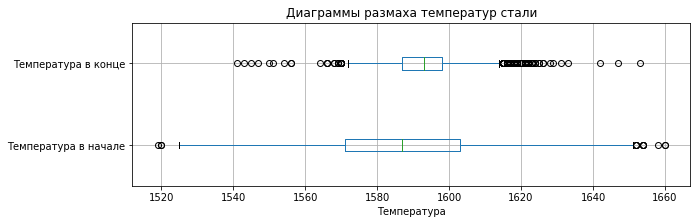

In [76]:
data_fin.loc[:,temp_columns].boxplot(vert=False, figsize=(10,3))
plt.xlabel('Температура')
plt.title('Диаграммы размаха температур стали');

Начальные температуры имеют более широкий размах значений. Также у начальных температур значительно шире ящик и усы.

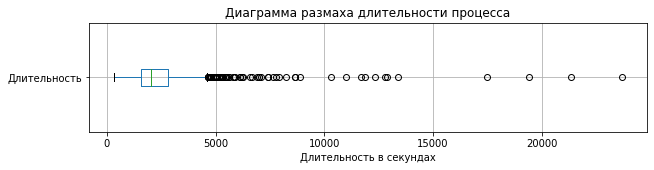

In [77]:
data_fin.loc[:,time_columns].boxplot(vert=False, figsize=(10,2))
plt.xlabel('Длительность в секундах')
plt.title('Диаграмма размаха длительности процесса');

Длительность имеет очень широкий диапазон значений. Выбросы доходят до 6.5 часов, при медианном значении в примерно полчаса.

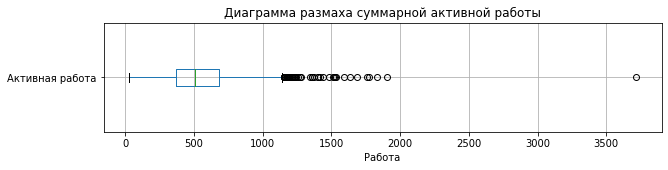

In [78]:
data_fin.loc[:,work_columns].boxplot(vert=False, figsize=(10,2))
plt.xlabel('Работа')
plt.title('Диаграмма размаха суммарной активной работы');

Активная работа имеет один явно выраженный выброс. Вероятно в этом процессе была высокая мощность и очень большая длительность нагрева.

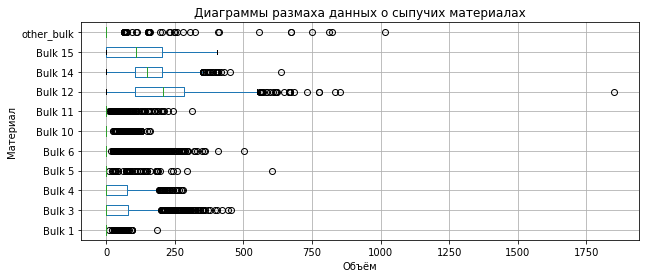

In [79]:
data_fin.loc[:,bulk_columns].boxplot(vert=False, figsize=(10,4))
plt.title('Диаграммы размаха данных о сыпучих материалах')
plt.xlabel('Объём')
plt.ylabel('Материал');

Столбец `Bulk 12` имеет одно очень большое значение. Из-за этого на графике сложно оценить размах некоторых столбцов, ограничим значения до 750.  
Также на график имеет большое влияние нулевые значения у редких материалов, из-за чего значение первого и третьего квартиля становится также равным нулю. Рассмотрим размах ненулевых значений.

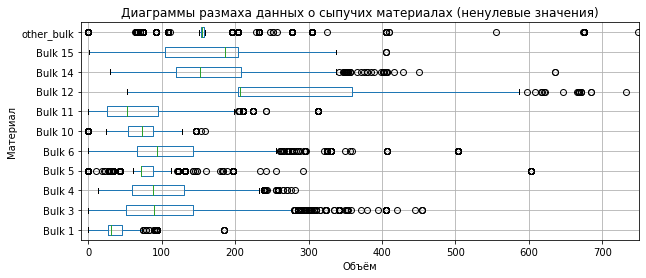

In [80]:
# Самый простой вариант не учитывать нули в графике это заменить их на None
data_fin.loc[:,bulk_columns].replace(0,None).boxplot(vert=False, figsize=(10,4))

plt.title('Диаграммы размаха данных о сыпучих материалах (ненулевые значения)')
plt.xlabel('Объём')
plt.ylabel('Материал')
plt.xlim(-10,750);

Теперь можно оценить объём материалов. Так, например, обычно материала `Bulk 12` добавляется больше других.   
А вот `Bulk 1` имеет наименьшее медианное значение.

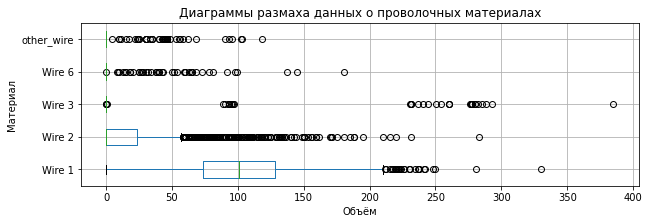

In [81]:
data_fin.loc[:,wire_columns].boxplot(vert=False, figsize=(10,3))
plt.title('Диаграммы размаха данных о проволочных материалах')
plt.xlabel('Объём')
plt.ylabel('Материал');

Также, как и с сыпучими материалами, отделим ненулевые значения.

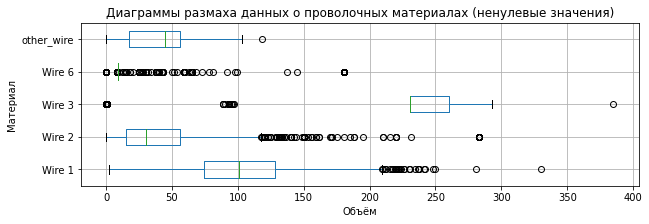

In [82]:
data_fin.loc[:,wire_columns].replace(0,None).boxplot(vert=False, figsize=(10,3))

plt.title('Диаграммы размаха данных о проволочных материалах (ненулевые значения)')
plt.xlabel('Объём')
plt.ylabel('Материал');

`Wire 3` и `Wire 6` имеют относительно небольшое число записей (63 и 73 соответственно).  
Из остальных материалов большую медиану имеет материал `Wire 1`

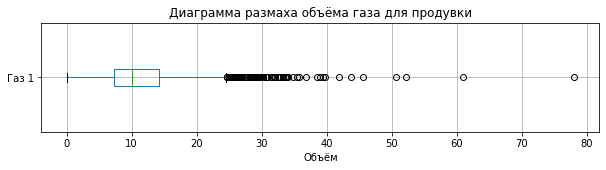

In [83]:
data_fin.loc[:,gas_columns].boxplot(vert=False, figsize=(10,2))
plt.xlabel('Объём')
plt.title('Диаграмма размаха объёма газа для продувки');

Медианный объём примерно 10, выбросы доходят до 80.

### Проверка корреляций

Посмотрим на значения корреляции в получившейся таблице.

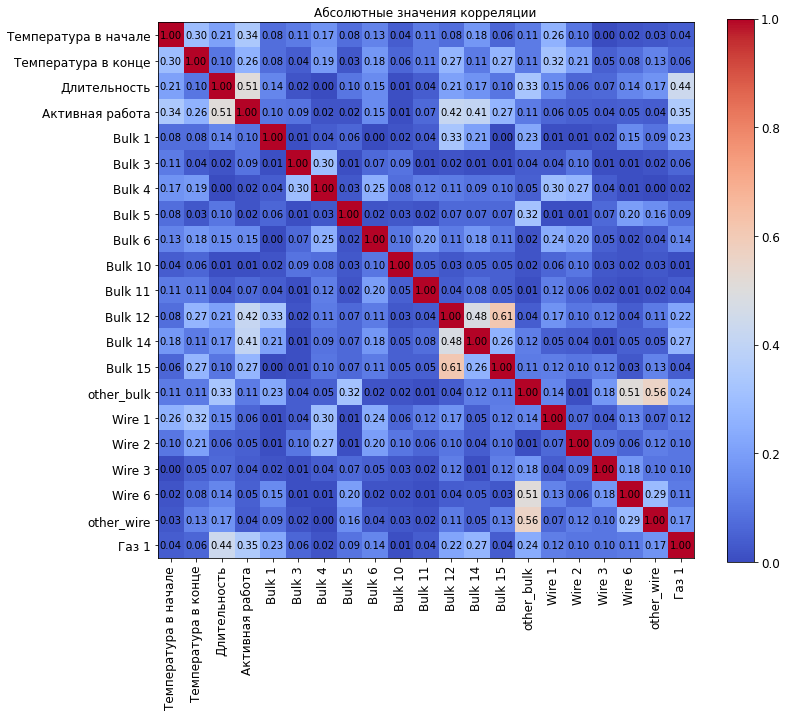

In [85]:
cor_df = data_fin.corr().round(2).abs()
# Step 1: Initiating a fig and axis object
fig, ax = plt.subplots(figsize = (12, 10))
ax.set_title('Абсолютные значения корреляции')
# Step 2: Create a plot
cax = ax.imshow(cor_df.values, interpolation='nearest', cmap = 'coolwarm', vmin = 0, vmax = 1)
# Step 3: Set axis tick labels 
ax.set_xticks(ticks = range(len(data_fin.columns)))
ax.set_yticks(ticks = range(len(data_fin.columns)))
ax.set_xticklabels(data_fin.columns)
ax.set_yticklabels(data_fin.columns)
# Step 4: Resize the tick parameters
ax.tick_params(axis = "x", labelsize = 12, labelrotation = 90)
ax.tick_params(axis = "y", labelsize = 12, labelrotation = 0)
# Step 5: Adding a color bar
fig.colorbar(cax).ax.tick_params(labelsize = 12)
# Step 6: Add annotation
for (x, y), t in np.ndenumerate(cor_df):
    ax.annotate("{:.2f}".format(t),
                 xy = (x, y),
                 va = "center", # vertical position
                 ha = "center") # horizontal position

Очень высоких значений кореляции нет, это хорошо.  
Самую высокую корреляцию (0.61) между собой имеют параметры `Bulk 12` и `Bulk 15`.  

Целевой признак финальной температуры имеет наибольшую корреляцию (0.32) с параметром `Wire 1`. Также похожая корреляция (0.3) с начальной температурой.

### Разделение на выборки

Целевым признаком в задаче является финальная температура.

In [86]:
x = data_fin.drop('Температура в конце', axis=1)
y = data_fin['Температура в конце']

Разделяем на выборки, размер тестовой выборки 25%.

In [87]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=random_state)

In [88]:
print('Размер тренировочной выборки:', x_train.shape, y_train.shape)
print('Размер тестовой выборки:', x_test.shape, y_test.shape)

Размер тренировочной выборки: (1743, 20) (1743,)
Размер тестовой выборки: (582, 20) (582,)


### Стандартизация данных

Обучим `StandardScaler` на тренировочных данных, после чего также применим его к  тестовым данным.

In [89]:
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [90]:
print(x_train_scaled[0])
x_train_scaled.mean().round(2), x_train_scaled.std()

[-1.41341918  0.64996318  0.67601457 -0.27702765 -0.63943757 -0.62494368
 -0.11551042  0.02797797 -0.23329895 -0.18120027  1.69704924  1.25752831
  1.09705475 -0.10494867 -1.59623748 -0.08767025 -0.11475517 -0.11531385
 -0.13969914  2.14078324]


(-0.0, 1.0)

## Обучение моделей

### Логистическая регрессия

In [91]:
%%time
linear_model = LinearRegression()
scores = cross_val_score(linear_model, x_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
result_linear = pd.Series(scores).abs().mean()
round(result_linear, 3)

CPU times: user 59.9 ms, sys: 89.2 ms, total: 149 ms
Wall time: 413 ms


6.504

У первой же модели неплохой результат.

### Рандомный лес

In [92]:
forest_model = RandomForestRegressor(random_state=random_state)
forest_parameters = {'n_estimators' : range(100,1001,100),
               'max_depth'    : range(4,11,1)}

In [93]:
%%time
forest_rscv = RandomizedSearchCV(estimator=forest_model, param_distributions = forest_parameters,
                                   cv = 5, scoring='neg_mean_absolute_error', 
                                    n_iter = 10, n_jobs=-1, random_state=random_state)
forest_rscv.fit(x_train_scaled, y_train);

CPU times: user 2min 50s, sys: 2.39 s, total: 2min 53s
Wall time: 12min 49s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=40823),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(4, 11),
                                        'n_estimators': range(100, 1001, 100)},
                   random_state=40823, scoring='neg_mean_absolute_error')

In [94]:
print("Результаты поиска для рандомного леса:" )
print("Лучший результат:", round(forest_rscv.best_score_ * -1, 3))
print("Параметры лучшей модели:", forest_rscv.best_params_)

Результаты поиска для рандомного леса:
Лучший результат: 6.497
Параметры лучшей модели: {'n_estimators': 400, 'max_depth': 10}


Результат чуть лучше, чем у линейной регрессии.

### CatBoost

In [95]:
cat_model = CatBoostRegressor(random_seed=random_state)
cat_parameters = {'iterations' : range(100,1001,100),
                  'depth'    : range(4,11,1)}

In [96]:
%%time
cat_rscv = RandomizedSearchCV(estimator=cat_model, param_distributions = cat_parameters,
                                   cv = 5, scoring='neg_mean_absolute_error', 
                                    n_iter = 10, n_jobs=-1, random_state=random_state)
cat_rscv.fit(x_train_scaled, y_train, verbose=0);

CPU times: user 3min 47s, sys: 8.17 s, total: 3min 55s
Wall time: 23min 49s


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f1e61936760>,
                   n_jobs=-1,
                   param_distributions={'depth': range(4, 11),
                                        'iterations': range(100, 1001, 100)},
                   random_state=40823, scoring='neg_mean_absolute_error')

In [97]:
print("Результаты поиска для CatBoost:" )
print("Лучший результат:", round(cat_rscv.best_score_ * -1, 3))
print("Параметры лучшей модели:", cat_rscv.best_params_)

Результаты поиска для CatBoost:
Лучший результат: 6.34
Параметры лучшей модели: {'iterations': 900, 'depth': 6}


Результат ещё немного лучше предыдущих.

### LightGBM

In [98]:
%%time
lgbm_rscv = RandomizedSearchCV(estimator=lgbm_model, param_distributions = lgbm_parameters,
                                   cv = 5, scoring='neg_mean_absolute_error', 
                                    n_iter = 20, n_jobs=-1, random_state=random_state)
lgbm_rscv.fit(x_train_scaled, y_train);lgbm_model = LGBMRegressor(random_seed=random_state)
lgbm_parameters = {'n_estimators' : range(100,2001,100),
                   'max_depth'    : range(10,101,10),
                   'num_leaves': range(20, 201, 20)}

In [99]:
%%time
lgbm_rscv = RandomizedSearchCV(estimator=lgbm_model, param_distributions = lgbm_parameters,
                                   cv = 5, scoring='neg_mean_absolute_error', 
                                    n_iter = 20, n_jobs=-1, random_state=random_state)
lgbm_rscv.fit(x_train_scaled, y_train);

CPU times: user 4.77 s, sys: 87.8 ms, total: 4.86 s
Wall time: 3min 14s


In [100]:
print("Результаты поиска для LightGBM:" )
print("Лучший результат:", round(lgbm_rscv.best_score_ * -1, 3))
print("Параметры лучшей модели:", lgbm_rscv.best_params_)

Результаты поиска для LightGBM:
Лучший результат: 6.638
Параметры лучшей модели: {'num_leaves': 40, 'n_estimators': 100, 'max_depth': 90}


Худший результат из всех рассмотренных.

### Выбор лучшей модели

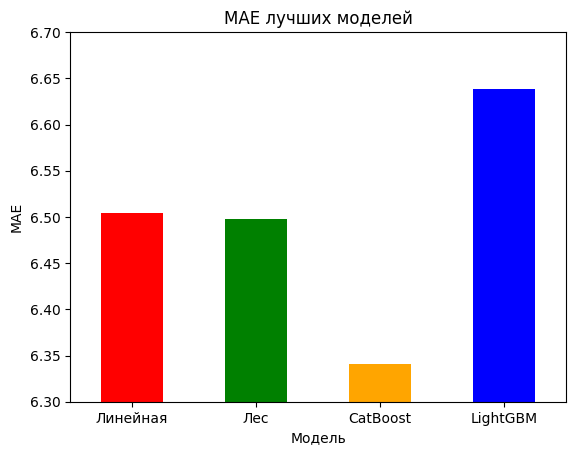

In [101]:
results = {'Линейная': result_linear, 
           'Лес': forest_rscv.best_score_ * -1, 
           'CatBoost': cat_rscv.best_score_ * -1,
           'LightGBM': lgbm_rscv.best_score_ * -1}
results = pd.Series(results)
results.plot.bar(rot=0,color=['r','g','Orange','b'])
plt.title('MAE лучших моделей')
plt.ylabel("MAE")
plt.xlabel("Модель")
plt.ylim(6.3,6.7)
plt.show()

Лучший результат показал CatBoost.   
Обучим модель заново на всех тренировочных данных.

In [102]:
best_model = cat_rscv.best_estimator_
best_model.fit(x_train_scaled, y_train, verbose=0);

## Анализ лучшей модели

### Тестирование модели

In [103]:
best_predict = best_model.predict(x_test_scaled)
mean_absolute_error(y_test, best_predict)

6.692660648576982

Требуемое значение MAE < 6.8 достигнуто.

In [104]:
r2_score(y_test, best_predict)

0.4087717556556054

Значение R2 больше нуля, что сразу говорит нам об адекватности модели. Однако результат довольно далеко от 1, что говорит о том, что зависимость целевого значения от параметров объяснена не очень хорошо.

Проверим модель на адекватность.

In [105]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(x_train_scaled, y_train)
dummy_predict = dummy_regr.predict(x_test_scaled)
mean_absolute_error(y_test, dummy_predict)

8.51697215962525

MAE нашей модели меньше, значит проверка пройдена.

### Изучение важности параметров

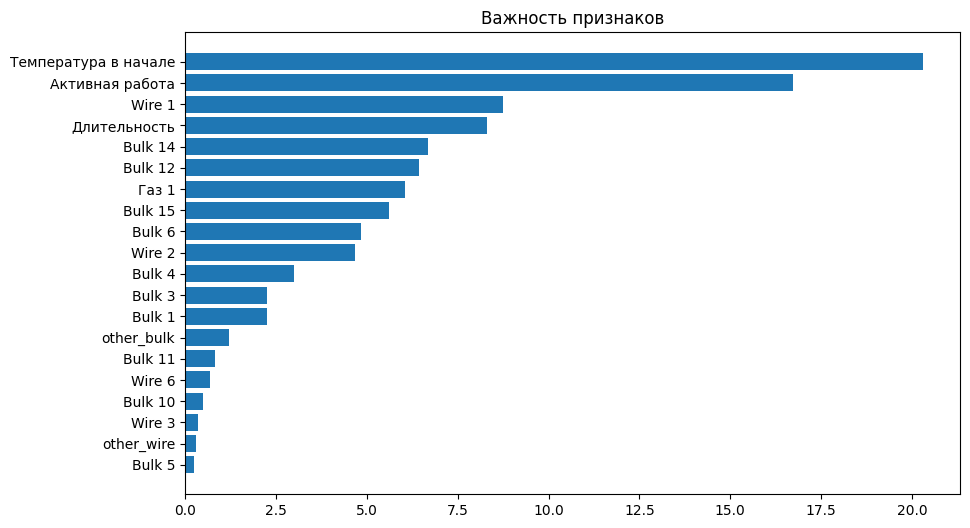

In [106]:
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_test.columns)[sorted_idx])
plt.title('Важность признаков');

Самым важным параметром является начальная температура стали. Логично: чем горячее или холоднее была сталь изначально, тем горячее или холоднее она будет в конце.  
Вторым по важности параметром является активная работа. Чем сильнее сталь нагреть, тем горячее она будет.  
Следующим параметром оказался `Wire 1`. Что интересно, по диаграмме размаха можно видеть, что этого материала добавляется не больше других. Вероятно играет роль какое-то свойство этого материала.  
Также важной является длительость процесса. Пассивное охлаждение от окружающей среды также играет свою роль.  
Далее идут параметры объёма материалов и газа. Причём чем более редким является материал, тем меньше его важность для модели.

### Вывод

Лучшей моделью является **CatBoost** с параметрами:
* iterations = 900 
* depth = 6

На тестовой выборке модель показала следующий результат:   
$MAE = 6.69$

***
Анализ важности признаков: 

Самым важным параметром является начальная температура стали.      
Вторым по важности параметром является активная работа.   
Следующим параметром оказался Wire 1.   
Также важной является длительность процесса.   
Далее идут параметры объёма материалов и чем более редким является материал, тем меньше его важность для модели.

## Отчёт

## Сравнение с планом

При обработке данных было решено не устранять выбросы, даже из тренировочный выборки.  
Выбросы в тренировочной выборке могуть помочь модели обучиться и справляться с ними в тестовой выборке. Так как выбросы являются, хоть и редкой, но всё же частью рабочего процесса. И в тестовых данных мы не можем устранить выбросы.

При обучении моделей было решено не использовать полносвязную нейронную сеть. Так как нейронные сети, всё же предназначены для других задач. А с регрессией хорошо справляются более классические модели.

При анализе модели, помимо метрики MAE была рассмотрена метрика R2. Которая позволяет быстро проверить модель на адекватность, а также оценить насколько хорошо описана зависисость целевого значения от параметров.

По остальным пунктам рабта выполнена по плану.

### Ключевые шаги проекта 

### Обработка данных

Данные из всех таблиц были объединены в единую таблицу с индексом по ключу.  
Перед объединением была проведена следующая обработка:

**Данные об электродах**   

Пропусков таблице нет. Ошибка есть в одной записи, но она не попадает в единую таблицу.

В единую таблицу добавлен только один параметр, вычисленный следующим образом:  
Суммарная активная работа. Вычисляется как сумма работы всех этапов нагрева по одному ключу. Для одного этапа работа вычисляется как произведение активной мощности на длительность процесса. Длительность прцесса вычисляется в секундах как разность конца и начала этапа нагрева.

**Данные о подаче сыпучих материалов (объём)**  

Редкие материалы `Bulk 2, Bulk 7, Bulk 8, Bulk 9, Bulk 13` были просуммированы и выделены в новый параметр `Other`. После чего эти материалыы были удалены из таблицы.  
Все пропуски заполнены нулями.  
Индексом таблицы установлен столбец `key`.

**Данные о проволочных материалах (объём)**

Редкие материалы `Wire 4, Wire 5, Wire 7, Wire 8, Wire 9` были просуммированы и выделены в новый параметр `Other`. После чего эти материалыы были удалены из таблицы.  
Все пропуски заполнены нулями.  
Индексом таблицы установлен столбец `key`.

**Данные о продувке сплава газом**

Индексом таблицы установлен столбец `key`.

**Результаты измерения температуры**

Сначала из таблицы были выделены ключи, у которых было меньше двух измерений температуры. Все записи с этими ключами были удалены из таблицы.  
После предыдущего действия в таблице не осталось пропусков.  

Для добавления в единую таблицу была создана новая таблица со следующими параметрами:
* Индекс ключ;
* Длительность процесса - разность (в секундах) последнего и первого времени замера температуры;
* Первый замер температуры;
* Последний замер температуры.

После этого из полученной таблицы были удалены все записи с замерами температуры ниже 1450°C (температура плавления стали).

Данные из таблиц **"Данные о проволочных материалах (время)"** и **"Данные о подаче сыпучих материалов (время)"** для составления единой таблицы не использовались.

Обработанные данные были объединены в единую таблицу методом `inner join`, позволяющим оставить только те ключи, по которым есть записи во всех таблицах.  
В объединённой таблице осталось 2325 записей со следующими столбцами:  
`Температура в начале, Температура в конце, Длительность, Активная работа, Bulk 1, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 10, Bulk 11, Bulk 12, Bulk 14, Bulk 15, other_bulk, Wire 1, Wire 2, Wire 3, Wire 6, other_wire, Газ 1`.

Перед обучением модели также было произведено разделение данных на тренировочную и тестовую выборки в соотношении 3:1. При разделении был использован `random_state = 40823`.

Также на тренировочных данных был обучен `StandardScaler`. После чего тренировочные и тестовые данные были стандартизированы.

### Обучение моделей

Во всех процессах, позволяющих использовать `random_state` (или `random_seed`) был указан `random_state=40823`.

**Логистическая регрессия**  

Модель `sklearn.linear_model.LinearRegression`   
Была проведена оценка метрики модели методом кросс-валидации с разделением на 5 выборок.   
Получена метрика `MAE = 6.504`

**Рандомный лес**

Модель `sklearn.ensemble.RandomForestRegressor`.  

Для перебора гиперпараметров был выбран следующий набор:
* Количесвтво деревьев от 100 по 1000, с шагом в 100;
* Максимальная глубина от 4 по 10, с шагом 1.

Была проведена кросс-валидация с выбором рандомных гиперпараметров методом `RandomizedSearchCV` с выбором 10 моделей, с разделением на 5 выборок.    
Лучший результат: `MAE = 6.497` с гиперпараметрами: `'n_estimators': 400, 'max_depth': 10`.

**CatBoost**

Модель `catboost.CatBoostRegressor`

Для перебора гиперпараметров был выбран следующий набор:
* Количество деревьев от 100 по 1000, с шагом в 100;
* Максимальная глубина от 4 по 10, с шагом 1.

Была проведена кросс-валидация с выбором рандомных гиперпараметров методом RandomizedSearchCV с выбором 10 моделей, с разделением на 5 выборок.  
Лучший результат: `MAE = 6.34` с гиперпараметрами: `'iterations': 900, 'depth': 6`.

**LightGBM**

Модель `lightgbm.LGBMRegressor`
Для перебора гиперпараметров был выбран следующий набор:

* Число деревьев от 100 по 2000, с шагом в 100;
* Максимальная глубина от 10 по 100, с шагом 10;
* Максимальное число листьев от 20 по 200 с шагом 20.

Была проведена кросс валидация с выбором рандомных гиперпараметров методом `RandomizedSearchCV` с выбором 20 моделей, с разделением на 5 выборок.  
Лучший результат: `MAE = 6.638` с гиперпараметрами: `'n_estimators': 100, 'max_depth': 90, 'num_leaves': 40`.

***
Из всех моделей лучший результат показала модель **CatBoost** с гиперпараметрами:
* iterations = 900 
* depth = 6
* random_state = 40823
***
Данная модель была заново обучена на полном наборе тренировочных данных.

### Анализ лучшей модели

На тестовой выборке модель показала следующие результаты:   
$MAE = 6.69$  
$R2 = 0.41$

Анализ важности признаков: 

Самым важным параметром является начальная температура стали.      
Вторым по важности параметром является активная работа.   
Следующим параметром оказался Wire 1.   
Также важной является длительость процесса.   
Далее идут параметры объёма материалов и гаЧём чем более редким является материал, тем меньше его важность для модели.

### Рекомендации по улучшению

При обработке данных не была учтена реактивная мощность электродов из-за высокой корреляции с активной мощностью.  
Для "деревянных" моделей, какой является CatBoost, скоррелированные данные не являются препятствием. Возможно, используя больше исходных данных, мы получим лучший результат.  

Также можно изучить порядок добавления материалов в процесс. Получить эти данные можно из таблиц с временем добавления материалов.   
Например, для каждого материала можно указать время в секундах, прошедшее после добавления первого материала. Конечно, более правильным было бы указать время, прошедшее с начала процесса, однако эта информация нам не доступна из-за несинхронизированности часов.  

Однако, при добавлении новых параметров, следует помнить, что слишком большое количество информации может быть даже хуже слишком малого. 

При обучении моделей были использованы только отностительно простые варианты. Помимо них можно попробовать использовать ансамблевые методы. Например бэггинг или бустинг.  
Возможно, сочетание разных моеделей поможет улучшить результат.